In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import  make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pylab
import seaborn as sns
import numpy as np
from IPython import display

import copy
import random
import time

Это игрушечно -исследовательское задание
Перед Вами задача бинарной классификации. Как модель мы будем использывать двуслойный перцептрон.
Изучите, как отрабатывают различные оптимизаторы на этой задаче. Обязательно попробовать  Adam, RMSProp, SGD, L-BFGS. Другие тоже можно

Сделать выводы по полученным результатам.

In [6]:
#  Делаем рандомную задачу бинарной классификации. По умолчанию make_classification порождает объект с 20 признаками. 
# Это значение можно варьировать. И его надо подавать как input_size в моддель
X, Y = make_classification(n_samples=200)

# Делим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=42)

# перегоняем все в торч
x_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

x_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [7]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([160, 20]),
 torch.Size([40, 20]),
 torch.Size([160]),
 torch.Size([40]))

In [9]:
# Cтроим простой перцептрончик: Один линейный слой потом Релу (что это такое, кстати?=)), еще линейный слой и сигмоиду, которая будет выдавать вероятности классов
# hidden size можно варьировать. input_size - кол-во признаков в объекте

class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size

        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.linear1(x)
        relu = self.relu(hidden)
        output = self.linear2(relu)
        output = self.sigmoid(output)
        return output

In [10]:
def draw(optimizers, n_epochs=200, batch_size=8):
    
    plt.figure(figsize=(20, 20))
    
    for k in range(0, len(optimizers), 2):
        optimizer = optimizers[k]

        sns.set()

        epoch_array = []
        epoch_test_array = []
        plt.subplot(2, 2, k // 2 + 1)
        cnt += 1
        for epoch in range(n_epochs):
            # Тут игрушечный пример как делить на батчи
            permutation = torch.randperm(x_train.size()[0])
            loss_array = []

            if k == len(optimizers) - 2:
                def closure():
                    optimizer.zero_grad()

                    # Бьем на батчи. В таком мигрушечном примере это не обязательно, но мы будем делать все по феншую
                    indices = permutation[i:i+batch_size]
                    batch_x, batch_y = x_train[indices], y_train[indices]

                    # Считаем лосс и добавляем его значение в массив
                    outputs = model.forward(batch_x)
                    loss = criterion(outputs.squeeze(), batch_y)

                    loss_array.append(loss.item())
                    loss.backward()

                    return loss

                model.train()
                for i in range(0,x_train.size()[0], batch_size):
                    optimizer.step(closure)
            else: 
                model.train()
                for i in range(0,x_train.size()[0], batch_size):

                    #  your code here 
                    optimizer.zero_grad()

                    # Бьем на батчи. В таком мигрушечном примере это не обязательно, но мы будем делать все по феншую
                    indices = permutation[i:i+batch_size]
                    batch_x, batch_y = x_train[indices], y_train[indices]

                    # Считаем лосс и добавляем его значение в массив
                    outputs = model.forward(batch_x)
                    loss = criterion(outputs.squeeze(), batch_y)

                    loss_array.append(loss.item())
                    loss.backward()

                    #  your code here 
                    optimizer.step()


            # Будем проверять как отрабатывает модель на тестовом датасете (ЗАЧЕМ?)
            # ТАк еж разбиваем на батчи, считаем лосс, но веса модели не обновляем
            test_permutation = torch.randperm(x_test.size()[0])
            loss_test_array = []
            model.eval()
            for i in range(0,x_test.size()[0], batch_size):

                indices = test_permutation[i:i+batch_size]
                batch_x, batch_y = x_test[indices], y_test[indices]
                outputs = model.forward(batch_x)
                loss = criterion(outputs.squeeze(), batch_y)
                loss_test_array.append(loss.item())

            # усредняем лосс на обучении и тесте по эпохе  и выводим график
            epoch_array.append(np.mean(loss_array))
            epoch_test_array.append(np.mean(loss_test_array))

            
        plt.title(optimizers[k + 1], fontsize=22)
        plt.plot(epoch_array, label ="TRAIN")
        plt.plot(epoch_test_array, label ="TEST")
        plt.legend(loc="best", fontsize=18)
    plt.show()

In [11]:
# модель
model = MLP(20, 10)

# Критерий/ функция потерь
criterion = torch.nn.BCELoss()

# Оптимизаторы. Можете потыкать все из торча. обязательно Adam, RMSProp, SGD, L-BFGS

lr = 0.00035
optimizers = [torch.optim.Adam(model.parameters(), lr=lr), "Adam",
              torch.optim.RMSprop(model.parameters(), lr=lr), "RMSprop", 
              torch.optim.SGD(model.parameters(), lr=lr), "SGD",
              torch.optim.LBFGS(model.parameters(), lr=lr), "L-BFGS"]

ОПИШИТЕ ПОЛУЧЕНННЫЕ РЕЗУЛЬТАТЫ

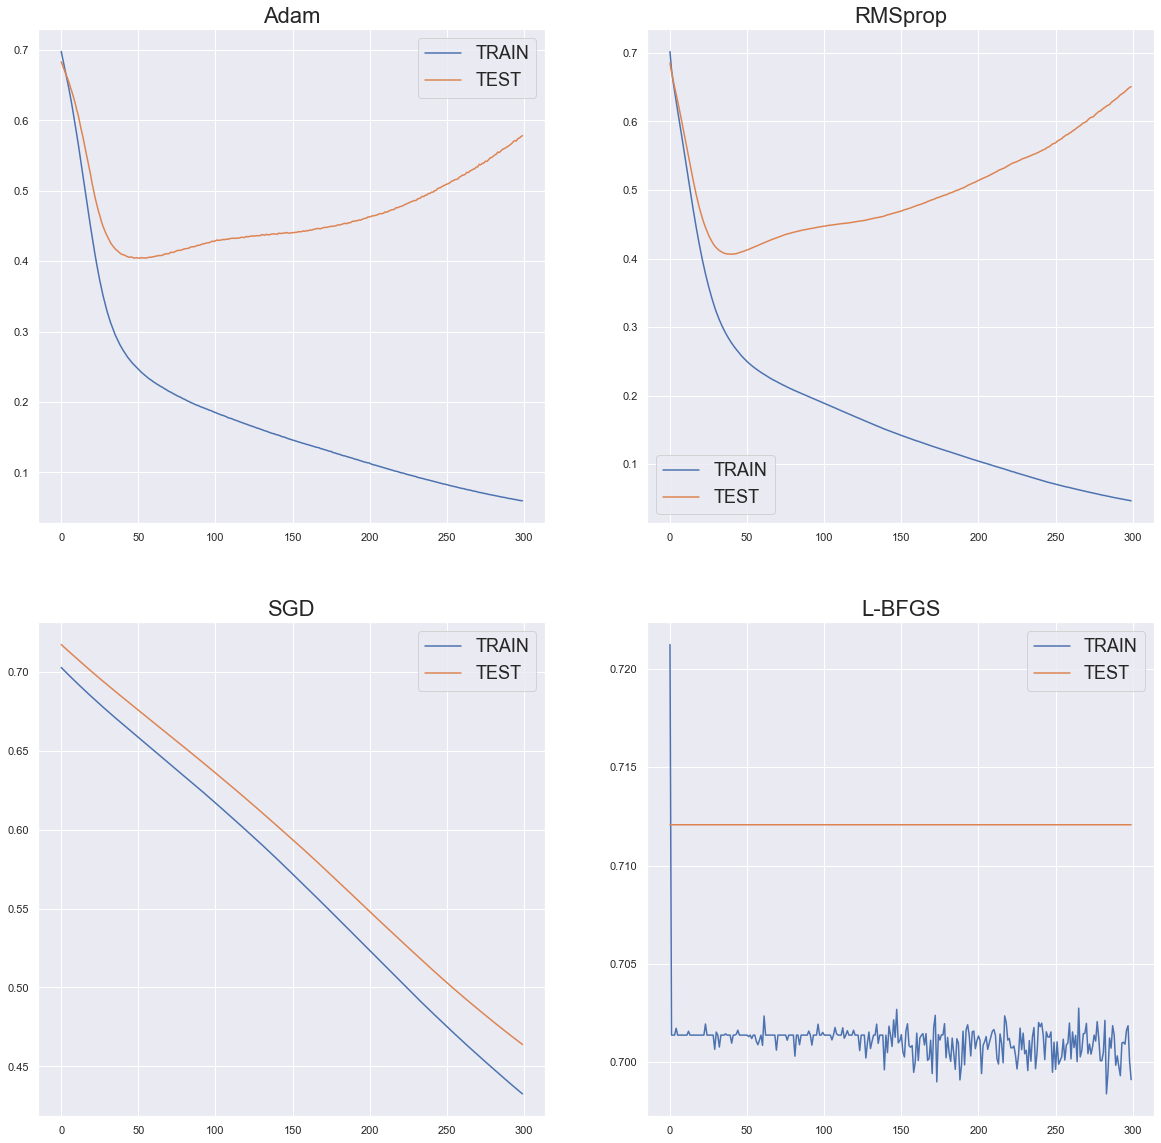

In [13]:
draw(optimizers, 300, 4)

Первые два графика очень похожи, но **RMSprop** в отличие от **Adam** имеет более крутой наклон как в начале, так и в конце. (В начале графики ближе друг к другу прижимаются, а потом быстрее отдаляются)

Что касаемо оставшихся двух графиков, то **SGD** является практически двумя параллельными прямыми, но всё равно чуть заметно отклонение *TEST* от *TRAIN*

В **L-BFGS** же всё гораздо труднее. В том плане, что кажется что график ошибочный, но даже после перезапусков он остаётся $\pm$ таким же, что конечно очень странно, но может там что-то не так с теми параметрами, к которым у нас не было доступа (*?*) - загадка)